C:\cygwin64\tmp\ipykernel_16020\4029700078.py:16: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(PathAwareDense, self).__init__(**kwargs)


=== ОБУЧЕНИЕ С АВТОМАТИЧЕСКИМ УСИЛЕНИЕМ ПУТИ ===
Путь будет усиливаться на каждой эпохе после 3 стабильных эпох

Эпоха 1/60
Время: 1.69 сек
Сила пути: 0.0866
Стабильность: 0/3 эпох
Точность: 0.6187

Эпоха 2/60
Время: 0.55 сек
Сила пути: 0.1188
Стабильность: 0/3 эпох
Точность: 0.7688

Эпоха 3/60
Время: 0.55 сек
Сила пути: 0.1547
Стабильность: 1/3 эпох
Точность: 0.8453

Эпоха 4/60
Время: 0.63 сек
Сила пути: 0.1801
Стабильность: 2/3 эпох
Точность: 0.8781

Эпоха 5/60
🚀 АВТОМАТИЧЕСКОЕ УСИЛЕНИЕ! Путь стабилен 3 эпох
✅ Веса усилены
Время: 0.63 сек
Сила пути: 0.1985
Стабильность: 3/3 эпох
Точность: 0.8875

Эпоха 6/60
🚀 АВТОМАТИЧЕСКОЕ УСИЛЕНИЕ! Путь стабилен 4 эпох
✅ Веса усилены
Время: 0.55 сек
Сила пути: 0.2180
Стабильность: 4/3 эпох
Точность: 0.9109

Эпоха 7/60
🚀 АВТОМАТИЧЕСКОЕ УСИЛЕНИЕ! Путь стабилен 5 эпох
✅ Веса усилены
Время: 0.63 сек
Сила пути: 0.2322
Стабильность: 5/3 эпох
Точность: 0.9281

Эпоха 8/60
🚀 АВТОМАТИЧЕСКОЕ УСИЛЕНИЕ! Путь стабилен 6 эпох
✅ Веса усилены
Время: 0.58 сек
Сила п

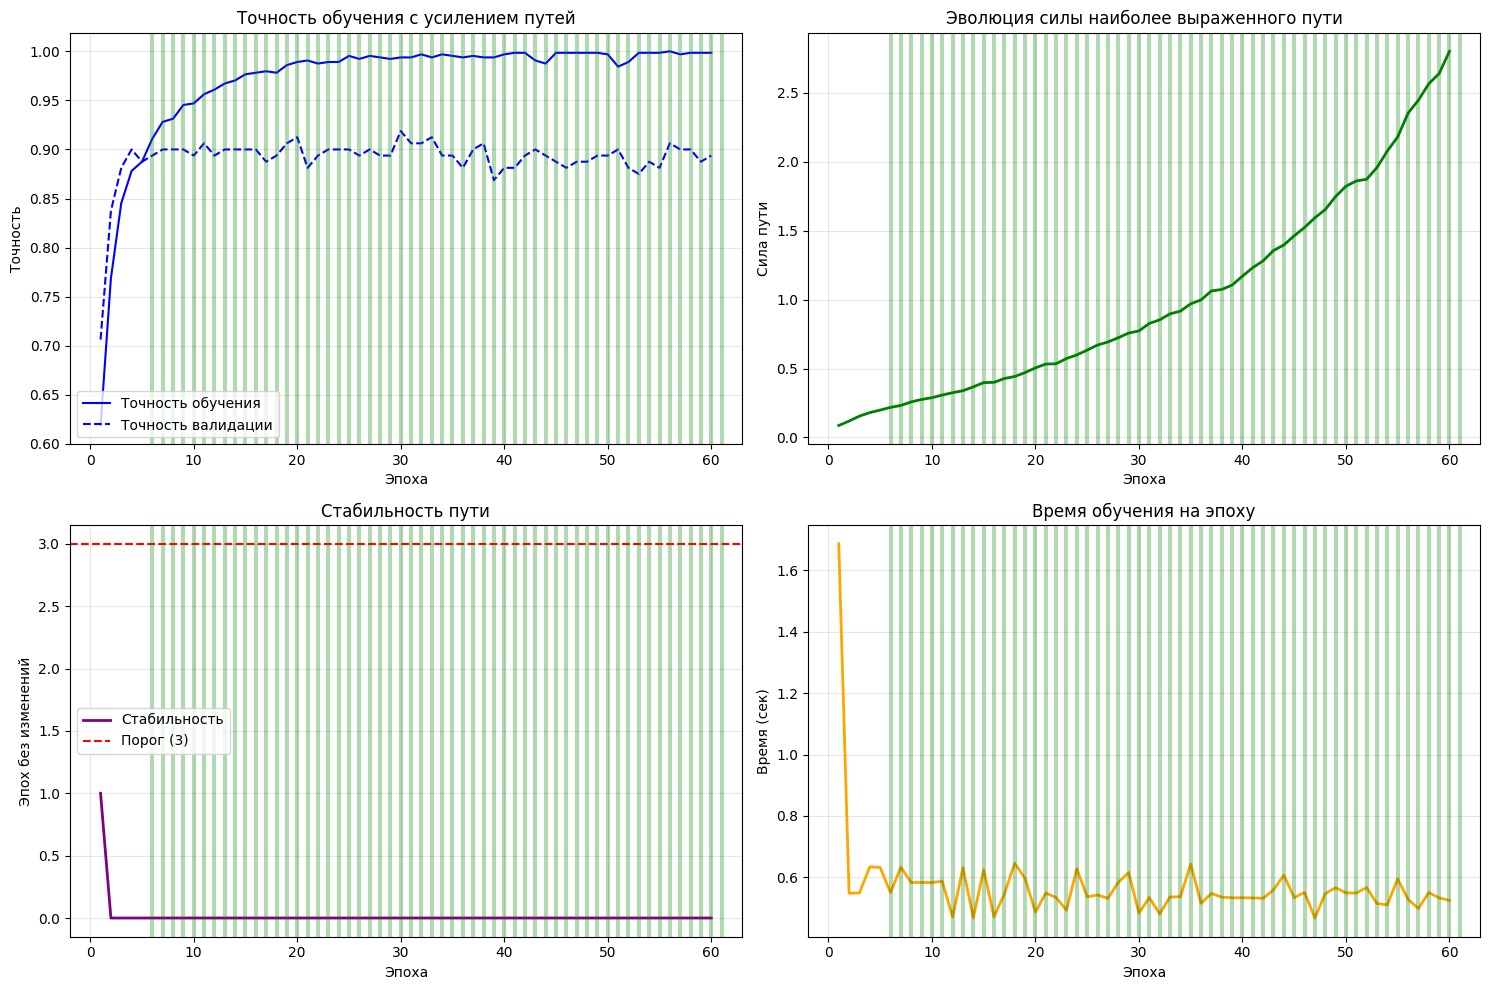

In [49]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Кастомный слой с отслеживанием пути
class PathAwareDense(Layer):
    def __init__(self, units, layer_id, activation='relu', **kwargs):
        super(PathAwareDense, self).__init__(**kwargs)
        self.units = units
        self.layer_id = layer_id
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
        # Информационная ценность каждого нейрона
        self.neuron_value = self.add_weight(
            shape=(self.units,),
            initializer='ones',
            trainable=False,
            name='neuron_value'
        )
        # Счетчик активаций
        self.activation_count = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=False,
            name='activation_count'
        )
        
    def call(self, inputs, training=None):
        # Вычисляем взвешенный выход
        output = tf.matmul(inputs, self.kernel * self.neuron_value) + self.bias
        activated_output = self.activation(output)
        
        if training:
            # Обновляем статистику активаций
            batch_activations = tf.reduce_mean(tf.cast(activated_output > 0.1, tf.float32), axis=0)
            self.activation_count.assign_add(batch_activations)
            
            # Обновляем информационную ценность на основе активаций и величины весов
            activation_ratio = self.activation_count / tf.reduce_max(self.activation_count)
            weight_magnitude = tf.reduce_mean(tf.abs(self.kernel), axis=0)
            
            # Комбинированная метрика информационной ценности
            new_value = 0.7 * activation_ratio + 0.3 * weight_magnitude
            self.neuron_value.assign(new_value)
        
        return activated_output

# Модель с поиском пути и стабилизацией
class PathAwareModel(Sequential):
    def __init__(self, stability_threshold=3, **kwargs):
        super(PathAwareModel, self).__init__(**kwargs)
        self.layer_graph = nx.DiGraph()
        self.best_path = None
        self.path_strength = 0
        self.train_accuracies = []
        self.val_accuracies = []
        self.train_losses = []
        self.val_losses = []
        self.path_strengths = []
        self.epoch_times = []
        self.samples_per_sec = []
        
        self.stability_threshold = stability_threshold
        self.stability_counter = 0
        self.enhancement_epochs = []
        self.current_path_hash = None
    
    def build_path_network(self):
        """Построение графа нейронной сети"""
        self.layer_graph.clear()
        
        # Добавляем узлы для входного слоя
        input_size = self.layers[0].kernel.shape[0]
        for i in range(input_size):
            self.layer_graph.add_node(f'input_{i}', value=1.0, layer=0)
        
        # Добавляем узлы и связи для скрытых слоев
        for layer_idx, layer in enumerate(self.layers):
            if hasattr(layer, 'neuron_value'):
                for neuron_idx in range(layer.units):
                    node_id = f'l{layer_idx}_n{neuron_idx}'
                    self.layer_graph.add_node(node_id, 
                                           value=layer.neuron_value[neuron_idx].numpy(),
                                           layer=layer_idx + 1)
                    
                    # Связи с предыдущим слоем
                    if layer_idx == 0:
                        # Связь с входным слоем
                        for prev_neuron in range(input_size):
                            weight = layer.kernel[prev_neuron, neuron_idx].numpy()
                            if abs(weight) > 0.01:
                                self.layer_graph.add_edge(f'input_{prev_neuron}', node_id, 
                                                        weight=abs(weight))
                    else:
                        # Связь с предыдущим скрытым слоем
                        prev_layer = self.layers[layer_idx - 1]
                        for prev_neuron in range(prev_layer.units):
                            weight = layer.kernel[prev_neuron, neuron_idx].numpy()
                            if abs(weight) > 0.01:
                                self.layer_graph.add_edge(f'l{layer_idx-1}_n{prev_neuron}', node_id, 
                                                        weight=abs(weight))
        
        # Добавляем выходной слой
        output_layer = self.layers[-1]
        for neuron_idx in range(output_layer.units):
            node_id = f'output_{neuron_idx}'
            self.layer_graph.add_node(node_id, value=1.0, layer=len(self.layers))
            
            # Связи с последним скрытым слоей
            last_hidden = self.layers[-2]
            for prev_neuron in range(last_hidden.units):
                weight = output_layer.kernel[prev_neuron, neuron_idx].numpy()
                if abs(weight) > 0.01:
                    self.layer_graph.add_edge(f'l{len(self.layers)-2}_n{prev_neuron}', node_id, 
                                            weight=abs(weight))
    
    def find_strongest_path(self):
        """Поиск наиболее сильного пути через сеть"""
        self.build_path_network()
        
        strongest_path = None
        max_strength = -1
        
        # Поиск путей от входных нейронов к выходным
        input_nodes = [n for n in self.layer_graph.nodes if self.layer_graph.nodes[n]['layer'] == 0]
        output_nodes = [n for n in self.layer_graph.nodes if self.layer_graph.nodes[n]['layer'] == len(self.layers)]
        
        for start_node in input_nodes:
            for end_node in output_nodes:
                try:
                    for path in nx.all_simple_paths(self.layer_graph, start_node, end_node):
                        path_strength = 1.0
                        for i in range(len(path) - 1):
                            edge_weight = self.layer_graph[path[i]][path[i+1]]['weight']
                            neuron_value = self.layer_graph.nodes[path[i+1]]['value']
                            path_strength *= edge_weight * neuron_value
                        
                        if path_strength > max_strength:
                            max_strength = path_strength
                            strongest_path = path
                except nx.NetworkXNoPath:
                    continue
        
        # Проверяем, изменился ли путь
        new_path_hash = hash(str(strongest_path)) if strongest_path else None
        path_changed = new_path_hash != self.current_path_hash
        
        if path_changed:
            self.stability_counter = 0
            self.current_path_hash = new_path_hash
        else:
            self.stability_counter += 1
        
        self.best_path = strongest_path
        self.path_strength = max_strength
        return strongest_path, max_strength
    
    def enhance_path_weights(self, enhancement_factor=1.1):
        """Усиление весов вдоль найденного пути"""
        if self.best_path is None:
            return False
        
        for i in range(len(self.best_path) - 1):
            node_from = self.best_path[i]
            node_to = self.best_path[i+1]
            
            if 'l' in node_to:
                layer_idx = int(node_to.split('_')[0][1:])
                neuron_to_idx = int(node_to.split('_')[1][1:])
                
                if 'input' in node_from:
                    neuron_from_idx = int(node_from.split('_')[1])
                    current_weight = self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx]
                    enhanced_weight = current_weight * enhancement_factor
                    self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx].assign(enhanced_weight)
                else:
                    neuron_from_idx = int(node_from.split('_')[1][1:])
                    current_weight = self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx]
                    enhanced_weight = current_weight * enhancement_factor
                    self.layers[layer_idx].kernel[neuron_from_idx, neuron_to_idx].assign(enhanced_weight)
        
        self.enhancement_epochs.append(len(self.train_accuracies))
        return True

# Генерация данных
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, 
                          n_informative=15, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Создание модели
STABILITY_THRESHOLD = 3
model = PathAwareModel(stability_threshold=STABILITY_THRESHOLD)
model.add(PathAwareDense(12, layer_id=0, input_dim=X_train.shape[1], activation='relu'))
model.add(PathAwareDense(8, layer_id=1, activation='relu'))
model.add(PathAwareDense(6, layer_id=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение
print("=== ОБУЧЕНИЕ С АВТОМАТИЧЕСКИМ УСИЛЕНИЕМ ПУТИ ===")
print(f"Путь будет усиливаться на каждой эпохе после {STABILITY_THRESHOLD} стабильных эпох")

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, 
                                                             test_size=0.2, 
                                                             random_state=42, 
                                                             stratify=y_train)

epochs = 60
for epoch in range(epochs):
    print(f"\nЭпоха {epoch + 1}/{epochs}")
    start = time.time()
    
    # Обучаем модель
    history = model.fit(X_train_final, y_train_final,
                       epochs=1,
                       batch_size=3,
                       validation_data=(X_val, y_val),
                       verbose=0)
    
    # Сохраняем метрики
    model.train_accuracies.append(history.history['accuracy'][0])
    model.val_accuracies.append(history.history['val_accuracy'][0])
    model.train_losses.append(history.history['loss'][0])
    model.val_losses.append(history.history['val_loss'][0])
    
    # Поиск пути
    best_path, path_strength = model.find_strongest_path()
    model.path_strengths.append(path_strength)
    
    # Автоматическое усиление на каждой эпохе после достижения стабильности
    if model.stability_counter >= STABILITY_THRESHOLD and best_path is not None:
        print(f"🚀 АВТОМАТИЧЕСКОЕ УСИЛЕНИЕ! Путь стабилен {model.stability_counter} эпох")
        model.enhance_path_weights(enhancement_factor=1.02)  # Меньший коэффициент для частого усиления
        print("✅ Веса усилены")
        # НЕ сбрасываем счетчик стабильности - продолжаем усиливать на каждой эпохе
    
    duration = time.time() - start
    model.epoch_times.append(duration)
    model.samples_per_sec.append(len(X_train_final) / duration)
    
    print(f"Время: {duration:.2f} сек")
    if best_path:
        print(f"Сила пути: {path_strength:.4f}")
        print(f"Стабильность: {model.stability_counter}/{STABILITY_THRESHOLD} эпох")
    print(f"Точность: {model.train_accuracies[-1]:.4f}")

# Результаты
print(f"\n=== РЕЗУЛЬТАТЫ ===")
print(f"Усиления произведены на эпохах: {model.enhancement_epochs}")
print(f"Общее количество усилений: {len(model.enhancement_epochs)}")
final_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Финальная точность: {final_accuracy:.4f}")

# Визуализация
def plot_results(model):
    plt.figure(figsize=(15, 10))
    
    # График 1: Точность и потери
    plt.subplot(2, 2, 1)
    epochs_range = range(1, len(model.train_accuracies) + 1)
    plt.plot(epochs_range, model.train_accuracies, 'b-', label='Точность обучения')
    plt.plot(epochs_range, model.val_accuracies, 'b--', label='Точность валидации')
    
    # Отмечаем эпохи усиления
    for enh_epoch in model.enhancement_epochs:
        plt.axvline(x=enh_epoch + 1, color='green', alpha=0.3, linestyle='-', linewidth=3)
    
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.title('Точность обучения с усилением путей')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График 2: Сила пути
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, model.path_strengths, 'g-', linewidth=2, label='Сила пути')
    
    for enh_epoch in model.enhancement_epochs:
        plt.axvline(x=enh_epoch + 1, color='green', alpha=0.3, linestyle='-', linewidth=3)
    
    plt.xlabel('Эпоха')
    plt.ylabel('Сила пути')
    plt.title('Эволюция силы наиболее выраженного пути')
    plt.grid(True, alpha=0.3)
    
    # График 3: Стабильность пути
    plt.subplot(2, 2, 3)
    stability_values = []
    counter = 0
    for i in range(len(model.path_strengths)):
        if i > 0 and model.path_strengths[i] != model.path_strengths[i-1]:
            counter = 0
        else:
            counter += 1
        stability_values.append(counter)
    
    plt.plot(epochs_range, stability_values, 'purple', linewidth=2, label='Стабильность')
    plt.axhline(y=STABILITY_THRESHOLD, color='red', linestyle='--', label=f'Порог ({STABILITY_THRESHOLD})')
    
    for enh_epoch in model.enhancement_epochs:
        plt.axvline(x=enh_epoch + 1, color='green', alpha=0.3, linestyle='-', linewidth=3)
    
    plt.xlabel('Эпоха')
    plt.ylabel('Эпох без изменений')
    plt.title('Стабильность пути')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График 4: Время обучения
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, model.epoch_times, 'orange', linewidth=2)
    
    for enh_epoch in model.enhancement_epochs:
        plt.axvline(x=enh_epoch + 1, color='green', alpha=0.3, linestyle='-', linewidth=3)
    
    plt.xlabel('Эпоха')
    plt.ylabel('Время (сек)')
    plt.title('Время обучения на эпоху')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_results(model)


ПЕРЕОБУЧЕНИЕ НА НОВЫХ ДАННЫХ
Точность на оригинальных тестовых данных: 0.9100
Точность на новых данных до переобучения: 0.3850

Начинаем переобучение на 40 эпох...

Переобучение: Эпоха 1/40
Время: 0.53 сек, Сила пути: 1.3141

Переобучение: Эпоха 2/40
Время: 0.59 сек, Сила пути: 1.1070

Переобучение: Эпоха 3/40
Время: 0.62 сек, Сила пути: 1.0136

Переобучение: Эпоха 4/40
🚀 УСИЛЕНИЕ ПРИ ПЕРЕОБУЧЕНИИ! Путь стабилен 3 эпох
✅ Веса усилены
Время: 0.61 сек, Сила пути: 0.9618

Переобучение: Эпоха 5/40
🚀 УСИЛЕНИЕ ПРИ ПЕРЕОБУЧЕНИИ! Путь стабилен 4 эпох
✅ Веса усилены
Время: 0.49 сек, Сила пути: 0.9842

Переобучение: Эпоха 6/40
🚀 УСИЛЕНИЕ ПРИ ПЕРЕОБУЧЕНИИ! Путь стабилен 5 эпох
✅ Веса усилены
Время: 0.51 сек, Сила пути: 1.0221

Переобучение: Эпоха 7/40
🚀 УСИЛЕНИЕ ПРИ ПЕРЕОБУЧЕНИИ! Путь стабилен 6 эпох
✅ Веса усилены
Время: 0.53 сек, Сила пути: 1.0459

Переобучение: Эпоха 8/40
🚀 УСИЛЕНИЕ ПРИ ПЕРЕОБУЧЕНИИ! Путь стабилен 7 эпох
✅ Веса усилены
Время: 0.51 сек, Сила пути: 1.0935

Переобучение: Эпоха 9

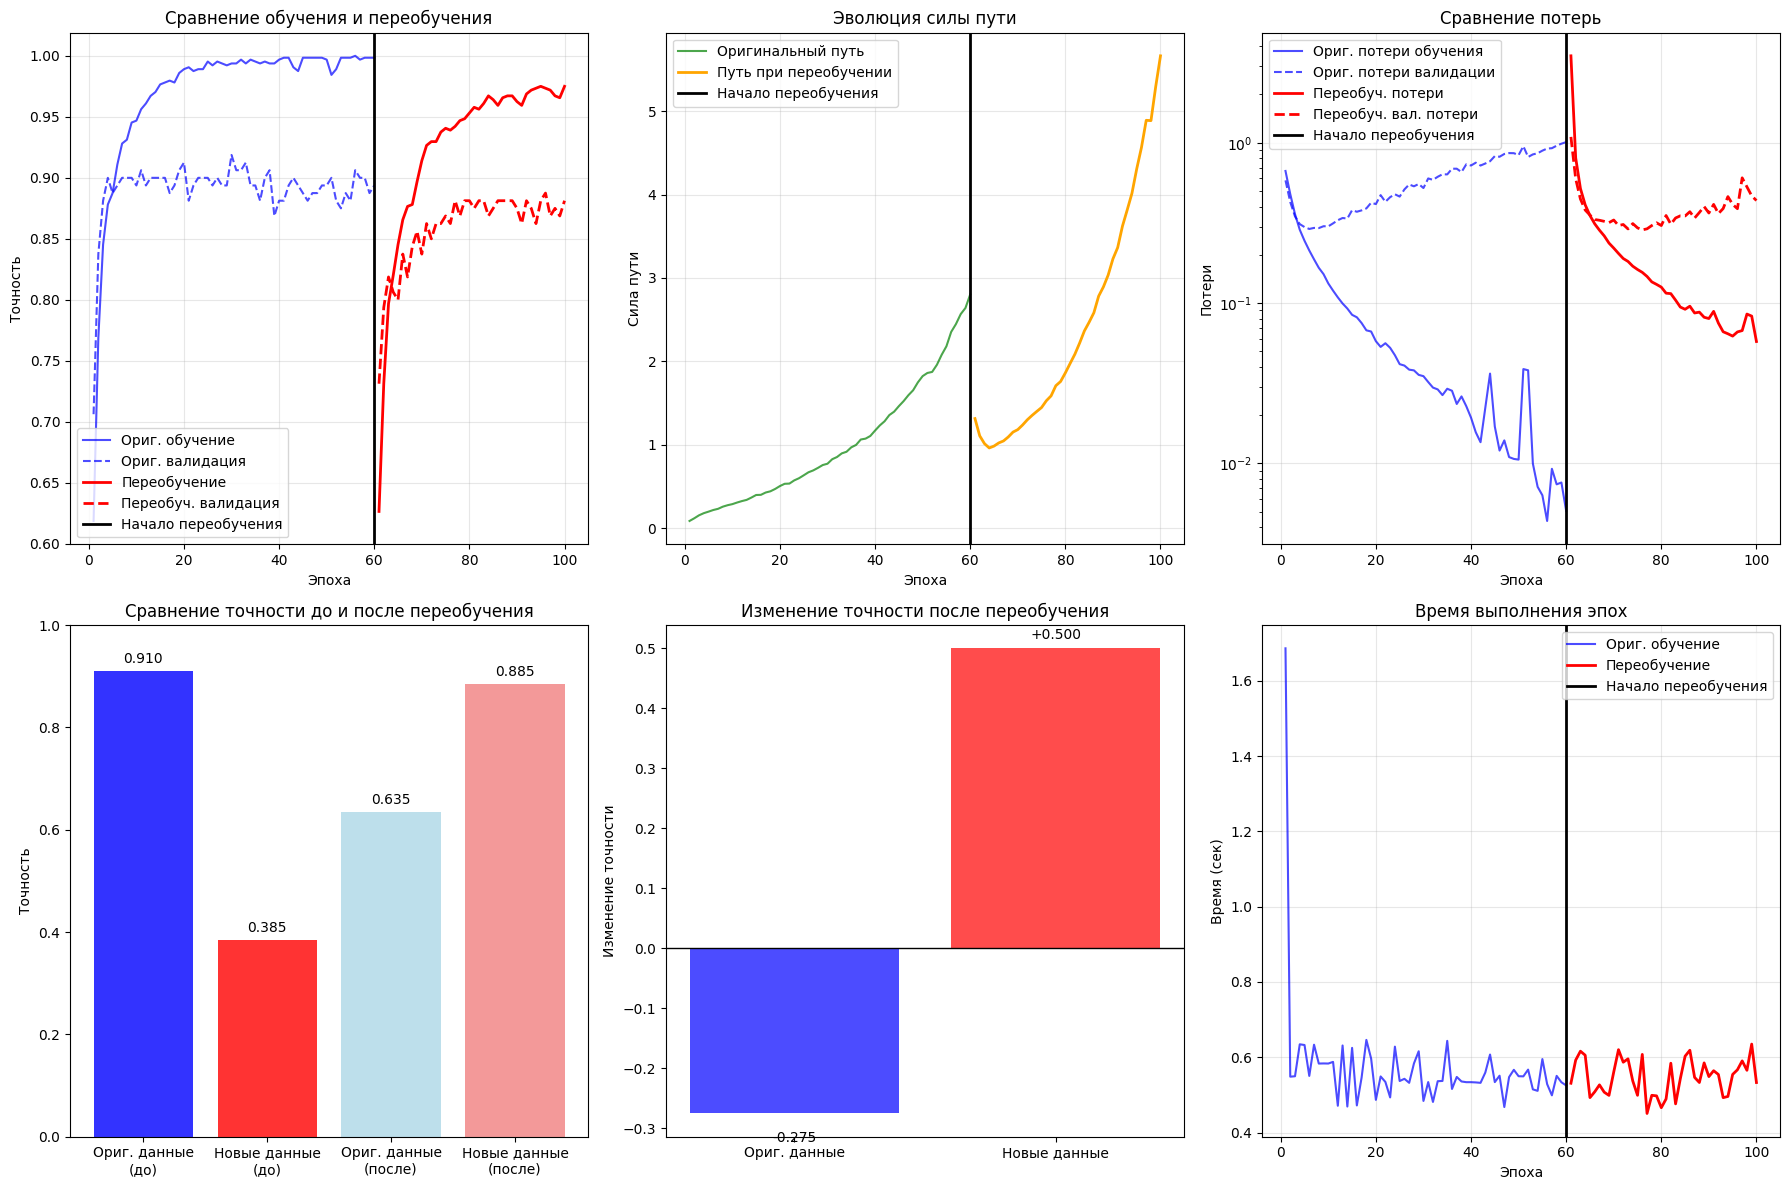


=== АНАЛИЗ ПЕРЕОБУЧЕНИЯ ===
❌ Обнаружено значительное переобучение: модель забыла оригинальные данные
✅ Отличная адаптация: модель хорошо научилась на новых данных


In [50]:
# Блок для переобучения на новых данных
print("\n" + "="*60)
print("ПЕРЕОБУЧЕНИЕ НА НОВЫХ ДАННЫХ")
print("="*60)

# Генерация новых данных с другим распределением (для демонстрации переобучения)
X_new, y_new = make_classification(n_samples=1000, n_features=20, n_classes=2, 
                          n_informative=15, n_redundant=5, random_state=456)
# X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, 
                          # n_informative=15, n_redundant=5, random_state=42)
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    X_new, y_new, test_size=0.2, random_state=456, stratify=y_new)

# Сохраняем оригинальные метрики для сравнения
original_test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
original_new_acc = model.evaluate(X_new_test, y_new_test, verbose=0)[1]

print(f"Точность на оригинальных тестовых данных: {original_test_acc:.4f}")
print(f"Точность на новых данных до переобучения: {original_new_acc:.4f}")

# Сбрасываем счетчики для отслеживания переобучения
model.enhancement_epochs = []
model.stability_counter = 0
model.current_path_hash = None

# Создаем списки для отслеживания метрик переобучения
retrain_train_acc = []
retrain_val_acc = []
retrain_train_loss = []
retrain_val_loss = []
retrain_path_strengths = []
retrain_epoch_times = []  # ← ДОБАВЛЯЕМ список для времени переобучения

# Переобучение на новых данных
retrain_epochs = 40
print(f"\nНачинаем переобучение на {retrain_epochs} эпох...")

for epoch in range(retrain_epochs):
    print(f"\nПереобучение: Эпоха {epoch + 1}/{retrain_epochs}")
    start = time.time()
    
    # Обучаем на новых данных
    history = model.fit(X_new_train, y_new_train,
                       epochs=1,
                       batch_size=3,
                       validation_split=0.2,
                       verbose=0)
    
    # Сохраняем метрики
    retrain_train_acc.append(history.history['accuracy'][0])
    retrain_val_acc.append(history.history['val_accuracy'][0])
    retrain_train_loss.append(history.history['loss'][0])
    retrain_val_loss.append(history.history['val_loss'][0])
    
    # Поиск пути
    best_path, path_strength = model.find_strongest_path()
    retrain_path_strengths.append(path_strength)
    
    # Сохраняем время выполнения эпохи ← ДОБАВЛЯЕМ ЭТУ СТРОЧКУ
    epoch_time = time.time() - start
    retrain_epoch_times.append(epoch_time)
    
    # Автоматическое усиление
    if model.stability_counter >= STABILITY_THRESHOLD and best_path is not None:
        print(f"🚀 УСИЛЕНИЕ ПРИ ПЕРЕОБУЧЕНИИ! Путь стабилен {model.stability_counter} эпох")
        model.enhance_path_weights(enhancement_factor=1.02)
        print("✅ Веса усилены")
    
    print(f"Время: {epoch_time:.2f} сек, Сила пути: {path_strength:.4f}")

# Оценка после переобучения
final_original_acc = model.evaluate(X_test, y_test, verbose=0)[1]
final_new_acc = model.evaluate(X_new_test, y_new_test, verbose=0)[1]

print(f"\n=== РЕЗУЛЬТАТЫ ПЕРЕОБУЧЕНИЯ ===")
print(f"Точность на оригинальных данных после переобучения: {final_original_acc:.4f}")
print(f"Точность на новых данных после переобучения: {final_new_acc:.4f}")
print(f"Изменение точности на оригинальных данных: {final_original_acc - original_test_acc:+.4f}")
print(f"Изменение точности на новых данных: {final_new_acc - original_new_acc:+.4f}")

# Визуализация результатов переобучения
def plot_retraining_results(model, retrain_train_acc, retrain_val_acc, retrain_path_strengths, retrain_epoch_times):  # ← ДОБАВЛЯЕМ ПАРАМЕТР
    plt.figure(figsize=(18, 12))
    
    # График 1: Сравнение точности до и после переобучения
    plt.subplot(2, 3, 1)
    epochs_range_original = range(1, len(model.train_accuracies) + 1)
    epochs_range_retrain = range(len(model.train_accuracies) + 1, 
                                len(model.train_accuracies) + len(retrain_train_acc) + 1)
    
    plt.plot(epochs_range_original, model.train_accuracies, 'b-', label='Ориг. обучение', alpha=0.7)
    plt.plot(epochs_range_original, model.val_accuracies, 'b--', label='Ориг. валидация', alpha=0.7)
    plt.plot(epochs_range_retrain, retrain_train_acc, 'r-', label='Переобучение', linewidth=2)
    plt.plot(epochs_range_retrain, retrain_val_acc, 'r--', label='Переобуч. валидация', linewidth=2)
    
    # Линия разделения оригинального обучения и переобучения
    plt.axvline(x=len(model.train_accuracies), color='black', linestyle='-', 
                linewidth=2, label='Начало переобучения')
    
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.title('Сравнение обучения и переобучения')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График 2: Сила пути до и после переобучения
    plt.subplot(2, 3, 2)
    plt.plot(epochs_range_original, model.path_strengths, 'g-', 
             label='Оригинальный путь', alpha=0.7)
    plt.plot(epochs_range_retrain, retrain_path_strengths, 'orange', 
             label='Путь при переобучении', linewidth=2)
    
    plt.axvline(x=len(model.train_accuracies), color='black', linestyle='-', 
                linewidth=2, label='Начало переобучения')
    
    plt.xlabel('Эпоха')
    plt.ylabel('Сила пути')
    plt.title('Эволюция силы пути')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График 3: Сравнение потерь
    plt.subplot(2, 3, 3)
    plt.plot(epochs_range_original, model.train_losses, 'b-', 
             label='Ориг. потери обучения', alpha=0.7)
    plt.plot(epochs_range_original, model.val_losses, 'b--', 
             label='Ориг. потери валидации', alpha=0.7)
    plt.plot(epochs_range_retrain, retrain_train_loss, 'r-', 
             label='Переобуч. потери', linewidth=2)
    plt.plot(epochs_range_retrain, retrain_val_loss, 'r--', 
             label='Переобуч. вал. потери', linewidth=2)
    
    plt.axvline(x=len(model.train_accuracies), color='black', linestyle='-', 
                linewidth=2, label='Начало переобучения')
    
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('Сравнение потерь')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # График 4: Сравнение точности на разных наборах данных
    plt.subplot(2, 3, 4)
    categories = ['Ориг. данные\n(до)', 'Новые данные\n(до)', 
                 'Ориг. данные\n(после)', 'Новые данные\n(после)']
    accuracies = [original_test_acc, original_new_acc, final_original_acc, final_new_acc]
    
    colors = ['blue', 'red', 'lightblue', 'lightcoral']
    bars = plt.bar(categories, accuracies, color=colors, alpha=0.8)
    
    plt.ylabel('Точность')
    plt.title('Сравнение точности до и после переобучения')
    plt.ylim(0, 1)
    
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # График 5: Разница в точности
    plt.subplot(2, 3, 5)
    diff_original = final_original_acc - original_test_acc
    diff_new = final_new_acc - original_new_acc
    
    plt.bar(['Ориг. данные', 'Новые данные'], [diff_original, diff_new], 
            color=['blue', 'red'], alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
    plt.ylabel('Изменение точности')
    plt.title('Изменение точности после переобучения')
    
    for i, diff in enumerate([diff_original, diff_new]):
        plt.text(i, diff + (0.01 if diff >= 0 else -0.03), f'{diff:+.3f}', 
                ha='center', va='bottom' if diff >= 0 else 'top')
    
    # График 6: Время обучения (ИСПРАВЛЕННЫЙ) ← ОБНОВЛЯЕМ ЭТОТ ГРАФИК
    plt.subplot(2, 3, 6)
    all_epoch_times = model.epoch_times + retrain_epoch_times  # ← ТЕПЕРЬ ИСПОЛЬЗУЕМ РЕАЛЬНЫЕ ДАННЫЕ
    all_epochs = range(1, len(all_epoch_times) + 1)
    
    # Разделяем на оригинальное обучение и переобучение
    split_point = len(model.epoch_times)
    
    plt.plot(all_epochs[:split_point], model.epoch_times, 'b-', 
             label='Ориг. обучение', alpha=0.7)
    plt.plot(all_epochs[split_point:], retrain_epoch_times, 'r-', 
             label='Переобучение', linewidth=2)
    
    plt.axvline(x=split_point, color='black', linestyle='-', 
                linewidth=2, label='Начало переобучения')
    
    plt.xlabel('Эпоха')
    plt.ylabel('Время (сек)')
    plt.title('Время выполнения эпох')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Запуск визуализации (ДОБАВЛЯЕМ ПАРАМЕТР)
plot_retraining_results(model, retrain_train_acc, retrain_val_acc, retrain_path_strengths, retrain_epoch_times)

# Дополнительный анализ переобучения
print("\n=== АНАЛИЗ ПЕРЕОБУЧЕНИЯ ===")
overfitting_indicator = final_original_acc - original_test_acc
if overfitting_indicator < -0.05:
    print("❌ Обнаружено значительное переобучение: модель забыла оригинальные данные")
elif overfitting_indicator < 0:
    print("⚠️  Небольшое переобучение: легкая деградация на оригинальных данных")
else:
    print("✅ Хорошая обобщающая способность: модель сохранила знания")

adaptation_indicator = final_new_acc - original_new_acc
if adaptation_indicator > 0.1:
    print("✅ Отличная адаптация: модель хорошо научилась на новых данных")
elif adaptation_indicator > 0:
    print("⚠️  Умеренная адаптация: небольшие улучшения на новых данных")
else:
    print("❌ Плохая адаптация: модель не смогла научиться на новых данных")